# set up and imports
## imports

In [2]:
import os
import scipy
import numpy as np
import matplotlib.pyplot as plt
import obspy
import pickle
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
import util
import pandas as pd
import math
import calc_durations
from scipy.stats import norm

In [3]:
import matplotlib
matplotlib.rcParams.update({'font.size': 20})

In [4]:
root = '/home/earthquakes1/homes/Rebecca/phd/data/2019_global_m3/' 

In [6]:
filenames = ['eq_object_05s_bandpass_01_19_snr_20_blank_0_new',
             'eq_object_05s_bandpass_01_19_snr_20_blank_005_new', 
             'eq_object_05s_bandpass_01_19_snr_20_blank_01_new',
             'eq_object_05s_bandpass_01_19_snr_20_blank_025_new',
             'eq_object_1s_bandpass_01_19_snr_20_blank_0_new', 
             'eq_object_1s_bandpass_01_19_snr_20_blank_005_new',
             'eq_object_1s_bandpass_01_19_snr_20_blank_01_new',
             'eq_object_1s_bandpass_01_19_snr_20_blank_025_new',
             'eq_object_1s_bandpass_01_19_snr_20_blank_05_new',
              'eq_object_4s_bandpass_01_19_snr_20_blank_0_new',
              'eq_object_4s_bandpass_01_19_snr_20_blank_005_new',
              'eq_object_4s_bandpass_01_19_snr_20_blank_01_new',
              'eq_object_4s_bandpass_01_19_snr_20_blank_025_new',
              'eq_object_4s_bandpass_01_19_snr_20_blank_05_new']

In [7]:
df = pd.read_pickle(f'/home/earthquakes1/homes/Rebecca/phd/data/results_database/{filenames[7]}')

# iv2

## load data for iv2

In [8]:
list_iv2_all = list(df.iv2)
list_mag_all = list(df.eq_mag)
list_dist_Distance = list(df.iv2_distances)
list_dist = []
list_mag = []
list_iv2 = []
eq = 0
for m in range(0, len(list_mag_all)):
    if list_mag_all[m]>5:
        someTrue = len(list_iv2_all[m])
        for d in range(0, len(list_dist_Distance[m])):
            if list_iv2_all[m][d] != None:
                list_mag.append(list_mag_all[m])
                list_iv2.append(list_iv2_all[m][d])
                list_dist.append(float(str(np.array(list_dist_Distance[m][d]))[:-3]))
            else:
                someTrue -= 1
        if someTrue >0:
            eq += 1
        
        

## iv2 calculations

### correct for distances
all these distances are epicentral

#### using $r^2$

In [9]:
dist_corr_mult = (np.array(list_dist)**2)*np.array(list_iv2)
df1  = pd.DataFrame({'iv2':np.log10(dist_corr_mult), 'mag':list_mag, 'dist':list_dist})

/tmp/ipykernel_2086823/1630682419.py:2: RuntimeWarning: invalid value encountered in log10
  df1  = pd.DataFrame({'iv2':np.log10(dist_corr_mult), 'mag':list_mag, 'dist':list_dist})


drop major outliers which arise from calculation problems

In [10]:
df1[df1.iv2 < -13].index

Int64Index([], dtype='int64')

In [11]:
df1.drop(df1[df1.iv2 < -13].index, inplace=True)
df1.drop(df1[df1.iv2 > 3].index, inplace=True)

#### using $r^{1.38}$

this comes from kuyuk and allen (2013)

In [12]:
dist_corr_mult_alt = (np.array(list_dist)**1.38)*np.array(list_iv2)
df2  = pd.DataFrame({'iv2':np.log10(dist_corr_mult_alt), 'mag':list_mag, 'dist':list_dist})

/tmp/ipykernel_2086823/3999979930.py:2: RuntimeWarning: invalid value encountered in log10
  df2  = pd.DataFrame({'iv2':np.log10(dist_corr_mult_alt), 'mag':list_mag, 'dist':list_dist})


drop major outliers which arise from calculation problems

In [13]:
df2.drop(df2[df2.iv2 < -13].index, inplace=True)
df2.drop(df2[df2.iv2 > 3].index, inplace=True)

## plotting

### scatter plots

#### with $r^2$

In [14]:
x = np.array(df1['mag'])-5
y = df1['iv2']
x_unique = np.arange(-2,3,0.1)
mask = ~np.isnan(x) & ~np.isnan(y)
result = scipy.stats.linregress(x[mask],y[mask])
a = result.slope
b = result.intercept

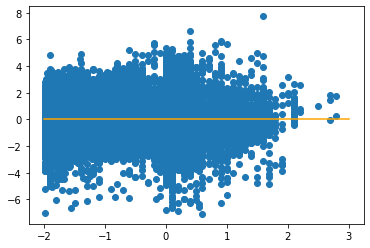

In [15]:
x_use = x
y_use = list(y)
y_pred = a*x_unique+b
x_ind = (x_use+2)*10
residuals = []
for i in range(0, len(x_use)):
    residuals.append(y_pred[int(x_ind[i])]-y_use[i])
plt.scatter(x_use, residuals)
plt.plot([-2,3],[0,0], color = 'orange')
#plt.savefig('/home/earthquakes1/homes/Rebecca/phd/seismo_det/figures/iv2_residual_plot.pdf')

In [16]:
mu = np.mean(np.ma.masked_invalid(y_use))
std = np.std(np.ma.masked_invalid(y_use))

/tmp/ipykernel_2086823/560078418.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  ax2.plot(x_pdf, p, 'k', linewidth=2, color = 'red')


(0.0, 0.25517740412019607)

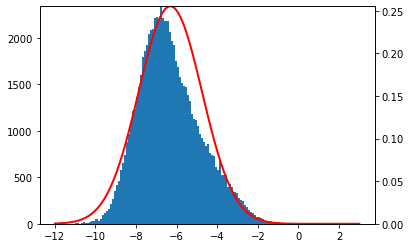

In [20]:
#ax = plt.subplot()
x_pdf = np.linspace(-12, 3, 100)
n, bins, _ = plt.hist(np.ma.masked_invalid(y_use), np.arange(-12,3,0.1), alpha = 0.2)
plt.close()
p = norm.pdf(x_pdf, mu, std)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(np.ma.masked_invalid(y_use), np.arange(-12,3,0.1), alpha = 1)
ax2 = ax.twinx()
ax2.plot(x_pdf, p, 'k', linewidth=2, color = 'red')
ax.set_ylim([0,max(n)])
ax2.set_ylim([0,max(p)])

#### using $r^{1.38}$

In [22]:
x = np.array(df2['mag'])-5
y = df2['iv2']
mask = ~np.isnan(x) & ~np.isnan(y)
x_unique = np.arange(-2,3,0.1)
result = scipy.stats.linregress(x[mask],y[mask])



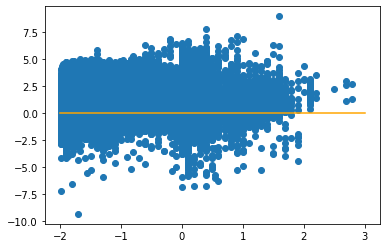

In [23]:
x_use = x
y_use = list(y)
y_pred = a*x_unique+b
x_ind = (x_use+2)*10
residuals = []
for i in range(0, len(x_use)):
    residuals.append(y_pred[int(x_ind[i])]-y_use[i])
plt.scatter(x_use, residuals)
plt.plot([-2,3],[0,0], color = 'orange')
#plt.savefig('/home/earthquakes1/homes/Rebecca/phd/seismo_det/figures/iv2_residual_plot.pdf')

In [24]:
mu = np.mean(np.ma.masked_invalid(y_use))
std = np.std(np.ma.masked_invalid(y_use))

/tmp/ipykernel_2086823/560078418.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  ax2.plot(x_pdf, p, 'k', linewidth=2, color = 'red')


(0.0, 0.24661188510803375)

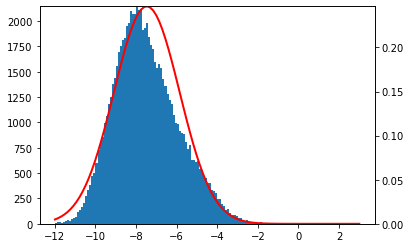

In [25]:
#ax = plt.subplot()
x_pdf = np.linspace(-12, 3, 100)
n, bins, _ = plt.hist(np.ma.masked_invalid(y_use), np.arange(-12,3,0.1), alpha = 0.2)
plt.close()
p = norm.pdf(x_pdf, mu, std)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(np.ma.masked_invalid(y_use), np.arange(-12,3,0.1), alpha = 1)
ax2 = ax.twinx()
ax2.plot(x_pdf, p, 'k', linewidth=2, color = 'red')
ax.set_ylim([0,max(n)])
ax2.set_ylim([0,max(p)])

/tmp/ipykernel_2086823/2860554692.py:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  ax2.plot(x_pdf, p, 'k', linewidth=2, color = 'red')


(0.0, 0.4593227534803408)

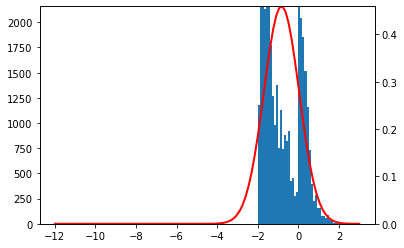

In [70]:
#ax = plt.subplot()
x_pdf = np.linspace(-12, 3, 100)
n, bins, _ = plt.hist(np.ma.masked_invalid(y_use), np.arange(-12,3,0.1), alpha = 0.2)
plt.close()
mu = np.mean(np.ma.masked_invalid(x_use))
std = np.std(np.ma.masked_invalid(x_use))
p = norm.pdf(x_pdf, mu, std)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(np.ma.masked_invalid(x_use), np.arange(-12,3,0.1), alpha = 1)
ax2 = ax.twinx()
ax2.plot(x_pdf, p, 'k', linewidth=2, color = 'red')
ax.set_ylim([0,max(n)])
ax2.set_ylim([0,max(p)])

### compare the results:

# predominant period

In [72]:
list_tp_all = list(df.tp_max)
list_mag_all = list(df.eq_mag)
list_mag = []
list_tpmax = []
for m in range(0, len(list_mag_all)):
    list_mag.append([])
    list_tpmax.append([])
    if list_mag_all[m]>5:
        for d in range(0, len(list_tp_all[m])):
            if list_tp_all[m][d] != None and list_tp_all[m][d]>0:
                list_mag[m].append(list_mag_all[m])
                list_tpmax[m].append(list_tp_all[m][d])

In [73]:
list_mags = list_mag_all

/home/earthquakes1/software/Ubuntu/anaconda3/envs/rlc2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/earthquakes1/software/Ubuntu/anaconda3/envs/rlc2/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


2000 2000


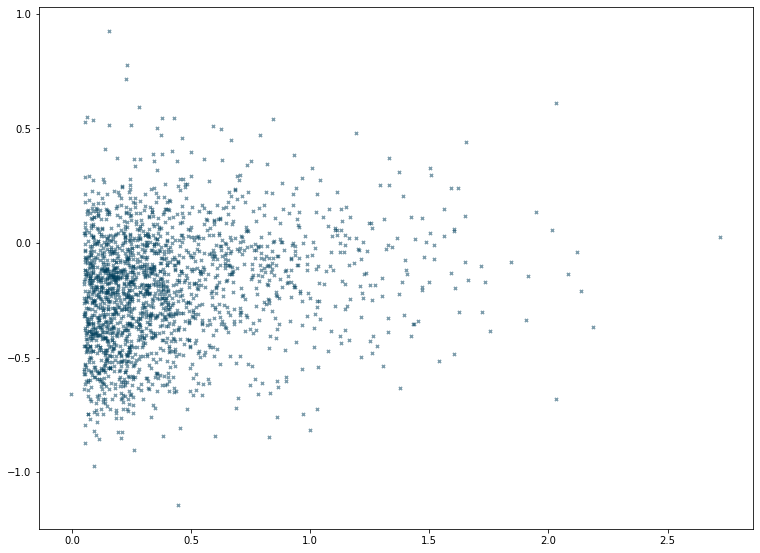

In [74]:
for n in [1]:#range(1, 10):#number of stations eq at least measured at
    med_for_ad = []
    mag_for_ad = []
    fig, axs = plt.subplots(1,1, figsize=(12.8,9.6))
    for mag_lim in [3.]:#, 3.4, 4.0, 4.4]:#np.arange(3.0, 6.5, 0.1):
        y_aves_tp = []
        x_aves_tp = []
        for i  in range(0, len(list_mags)):
            if list_mags[i] > mag_lim and list_mags[i]<=max(list_mags):
                #if list_mags[i] >= 4 and list_mags[i]<=5:
                if len(list_tpmax[i])>=n:
                    mean_tp = np.mean(list_tpmax[i]) 
                    std_tp = np.std(list_tpmax[i]) 
                    y_tp = [] 
                    for j in list_tpmax[i]: 
                        if j > mean_tp-2*std_tp and j < mean_tp + 2*std_tp:# and j < 100: 
                            y_tp.append(math.log(j, 10))
                        elif len(list_tpmax[i])==1:
                            y_tp.append(math.log(j, 10))
                    x_tp = np.zeros(len(y_tp))  
                    x_tp = x_tp + list_mags[i]
                    c = 0
                    if len(x_tp)>0 and mag_lim == 3.:
                        if math.isnan(np.median(y_tp))==False:
                            axs.scatter(list_mags[i]-5+np.random.uniform(-0.05, 0.05), np.median(y_tp), s = 10, c = '#003f5c', marker = 'x', zorder =110, alpha = 0.5)
                    if math.isnan(np.median(y_tp))==False:  
                        y_aves_tp.append(np.median(y_tp))
                        x_aves_tp.append(list_mags[i])
        if len(y_aves_tp)>0:
            x_use = np.array(x_aves_tp) - 5
            y_use = np.array(y_aves_tp)

            print(len(x_aves_tp), len(y_aves_tp))
    x = x_use
    y = y_use
    x_unique = np.arange(-2,3,0.1)
    df_tp = pd.DataFrame(columns = x_unique)

    result = scipy.stats.linregress(x,y)
    a = result.slope
    b = result.intercept

make a residual plot

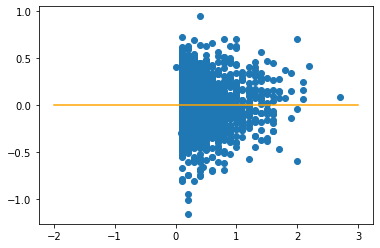

In [75]:
y_pred = a*x_unique+b
residuals = []
x_ind = (x_use+2)*10
for i in range(0, len(x_use)):
    residuals.append(y_pred[int(x_ind[i])]-y_use[i])
plt.scatter(x_use, residuals)
plt.plot([-2,3],[0,0], color = 'orange')
#plt.savefig('/home/earthquakes1/homes/Rebecca/phd/seismo_det/figures/residual_plot.pdf')

In [76]:
mu = np.mean(np.ma.masked_invalid(y_use))
std = np.std(np.ma.masked_invalid(y_use))

/tmp/ipykernel_2086823/316402427.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  ax2.plot(x_pdf, p, 'k', linewidth=2, color = 'red')


(0.0, 1.5613251841717841)

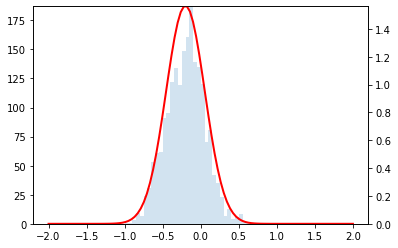

In [77]:
ax = plt.subplot()
x_pdf = np.linspace(-2, 2, 100)
n, bins, _ = plt.hist(np.ma.masked_invalid(y_use), np.arange(-2,2,0.05), alpha = 0.2)
#plt.close()
p = norm.pdf(x_pdf, mu, std)

#fig = plt.figure()
#ax = fig.add_subplot(111)
#ax.hist(np.ma.masked_invalid(y_use), np.arange(-12,3,0.1), alpha = 1)
ax2 = ax.twinx()
ax2.plot(x_pdf, p, 'k', linewidth=2, color = 'red')
ax.set_ylim([0,max(n)])
ax2.set_ylim([0,max(p)])
#ax.set_xlim([-2,2])

In [78]:
scipy.stats.spearmanr(x_use,y_use)


SpearmanrResult(correlation=0.2061390462797611, pvalue=1.2397728539468575e-20)

In [46]:
std

0.3030199823429823

# average period

## load data

In [87]:
title

'eq_object_05s_bandpass_01_19_snr_20_blank_005_new'

In [88]:
list_tc_all = list(df.tc)
list_mag_all = list(df.eq_mag)
list_mag = []
list_tc = []
for m in range(0, len(list_mag_all)):
    list_mag.append([])
    list_tc.append([])
    for d in range(0, len(list_tc_all[m])):
        if list_tc_all[m][d] != None and list_tc_all[m][d]>0:
            list_mag[m].append(list_mag_all[m])
            list_tc[m].append(list_tc_all[m][d])

In [89]:
len(list_tc)

7998

## plot data

7565 7565


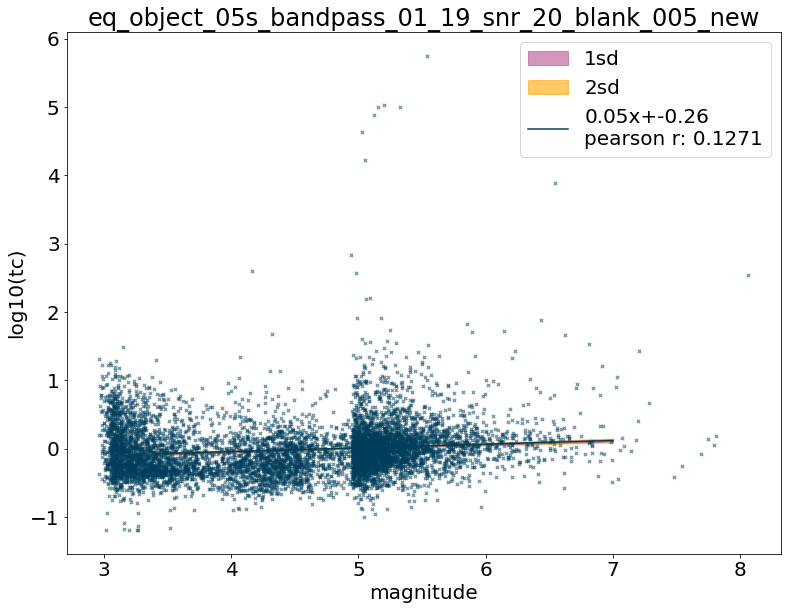

In [90]:
params = []
opacities = np.linspace(0.2,1,45)
import matplotlib.pyplot as plt
cs = ['midnightblue']
#fig, axs = plt.subplots(1,1, figsize=(12.8,9.6))
y_aves_tc = []
x_aves_tc = []
count = 1
eq_count = 0
n = 0
for n in [1]:#range(1, 10):#number of stations eq at least measured at
    med_for_ad = []
    mag_for_ad = []
    fig, axs = plt.subplots(1,1, figsize=(12.8,9.6))
    for mag_lim in [3.]:#, 3.4, 4.0, 4.4]:#np.arange(3.0, 6.5, 0.1):
        y_aves_tc = []
        x_aves_tc = []
        for i  in range(0, len(list_mags)):
            if list_mags[i] > mag_lim and list_mags[i]<=max(list_mags):
                #if list_mags[i] >= 4 and list_mags[i]<=5:
                if len(list_tc[i])>=n:
                    mean_tc = np.mean(list_tc[i]) 
                    std_tc = np.std(list_tc[i]) 
                    y_tc = [] 
                    for j in list_tc[i]: 
                        if j >= 0:
                            if j > mean_tc-2*std_tc and j < mean_tc + 2*std_tc:# and j < 100: 
                                y_tc.append(math.log(j, 10))
                            elif len(list_tc[i])==1:
                                y_tc.append(math.log(j, 10))
                    x_tc = np.zeros(len(y_tc))  
                    x_tc = x_tc + list_mags[i]
                    c = 0
                    if len(x_tc)>0 and mag_lim == 3:
                        if math.isnan(np.median(y_tc))==False:
                            axs.scatter(list_mags[i]-5+np.random.uniform(-0.05, 0.05), np.median(y_tc), s = 10, c = '#003f5c', marker = 'x', zorder =110, alpha = 0.5)
                    if math.isnan(np.median(y_tc))==False:  
                        y_aves_tc.append(np.median(y_tc))
                        x_aves_tc.append(list_mags[i])
        if len(y_aves_tc)>0:
            x_use = np.array(x_aves_tc) - 5
            y_use = np.array(y_aves_tc)

            print(len(x_aves_tc), len(y_aves_tc))
            count += 1
    x = x_use
    y = y_use
    x_unique = np.arange(-1.6,2.1,0.1)
    df_tc = pd.DataFrame(columns = x_unique)

    result = scipy.stats.linregress(x,y)
    a = result.slope
    b = result.intercept
    std_a = result.stderr
    std_b = result.intercept_stderr

    y_1 = (a+std_a)*x_unique + (b+std_b)
    y_2 = (a+std_a)*x_unique + (b-std_b)
    y_3 = (a-std_a)*x_unique + (b+std_b)
    y_4 = (a-std_a)*x_unique + (b-std_b)


    y_min_1sd = np.minimum(np.minimum(y_1, y_2), np.minimum(y_3, y_4))
    y_max_1sd = np.maximum(np.maximum(y_1, y_2), np.maximum(y_3, y_4))

    y_1 = (a+2*std_a)*x_unique + (b+2*std_b)
    y_2 = (a+2*std_a)*x_unique + (b-2*std_b)
    y_3 = (a-2*std_a)*x_unique + (b+2*std_b)
    y_4 = (a-2*std_a)*x_unique + (b-2*std_b)

    y_min_2sd = np.minimum(np.minimum(y_1, y_2), np.minimum(y_3, y_4))
    y_max_2sd = np.maximum(np.maximum(y_1, y_2), np.maximum(y_3, y_4))        

    #plt.scatter(x+np.random.uniform(-0.05, 0.05, len(x)),y, marker = 'x', color = 'k', s = 10, alpha = 0.5)
    axs.fill_between(x_unique, y_min_1sd, y_max_1sd, color = '#bc5090', alpha = 0.6, zorder = 100, label = '1sd')
    axs.fill_between(x_unique, y_min_2sd, y_max_2sd, color = '#ffa600', alpha = 0.6, zorder = 99, label = '2sd')
    popt = np.polyfit(x, y, 1)
    axs.plot(x_unique, popt[0]*x_unique+popt[1], color='#003f5c',zorder=102,label='{a:.2f}x+{b:.2f}\npearson r: {r:.4f}'.format(a=result.slope,b=result.intercept-5*result.slope,r=result.rvalue))
    axs.set_ylabel('log10(tc)')
    axs.set_xlabel('magnitude')   
    axs.set_xticks([-2,-1,0,1,2,3], [3,4,5,6,7,8], zorder = 110)
    axs.legend()
    #axs.set_ylim([-2,1])
    axs.set_title(title)
    plt.savefig('/home/earthquakes1/homes/Rebecca/phd/seismo_det/figures/all_data/tc/'+title+'_m3.pdf', format = 'pdf')
    

In [92]:
result

LinregressResult(slope=0.05415662244319286, intercept=0.011153724199054102, rvalue=0.12709147223305692, pvalue=1.2938608523839873e-28, stderr=0.004860176714646782, intercept_stderr=0.005103059042447004)

2743 2743


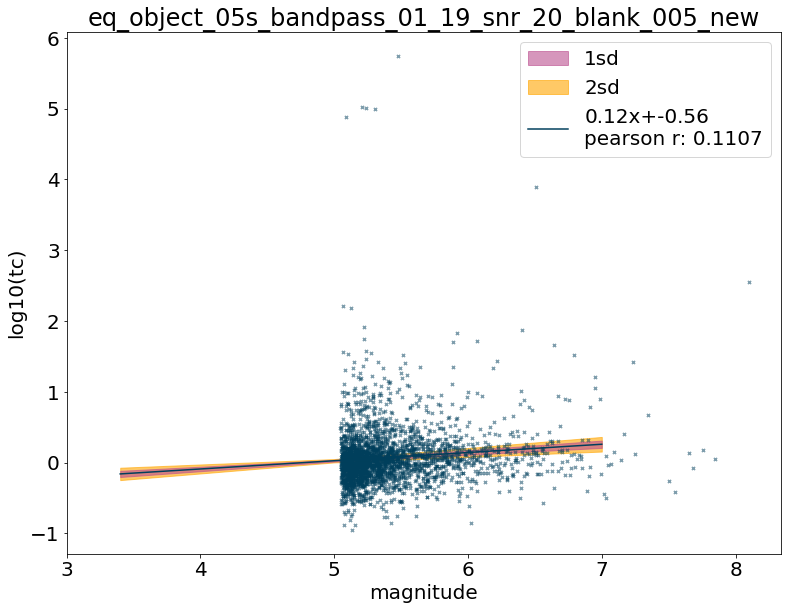

In [93]:
params = []
opacities = np.linspace(0.2,1,45)
import matplotlib.pyplot as plt
cs = ['midnightblue']
#fig, axs = plt.subplots(1,1, figsize=(12.8,9.6))
y_aves_tc = []
x_aves_tc = []
count = 1
eq_count = 0
n = 0
for n in [1]:#range(1, 10):#number of stations eq at least measured at
    med_for_ad = []
    mag_for_ad = []
    fig, axs = plt.subplots(1,1, figsize=(12.8,9.6))
    for mag_lim in [5.]:#, 3.4, 4.0, 4.4]:#np.arange(3.0, 6.5, 0.1):
        y_aves_tc = []
        x_aves_tc = []
        for i  in range(0, len(list_mags)):
            if list_mags[i] > mag_lim and list_mags[i]<=max(list_mags):
                #if list_mags[i] >= 4 and list_mags[i]<=5:
                if len(list_tc[i])>=n:
                    mean_tc = np.mean(list_tc[i]) 
                    std_tc = np.std(list_tc[i]) 
                    y_tc = [] 
                    for j in list_tc[i]: 
                        if j >= 0:
                            if j > mean_tc-2*std_tc and j < mean_tc + 2*std_tc:# and j < 100: 
                                y_tc.append(math.log(j, 10))
                            elif len(list_tc[i])==1:
                                y_tc.append(math.log(j, 10))
                    x_tc = np.zeros(len(y_tc))  
                    x_tc = x_tc + list_mags[i]
                    c = 0
                    if len(x_tc)>0 and mag_lim == 5:
                        if math.isnan(np.median(y_tc))==False:
                            axs.scatter(list_mags[i]-5+np.random.uniform(-0.05, 0.05), np.median(y_tc), s = 10, c = '#003f5c', marker = 'x', zorder =110, alpha = 0.5)
                    if math.isnan(np.median(y_tc))==False:  
                        y_aves_tc.append(np.median(y_tc))
                        x_aves_tc.append(list_mags[i])
        if len(y_aves_tc)>0:
            x_use = np.array(x_aves_tc) - 5
            y_use = np.array(y_aves_tc)

            print(len(x_aves_tc), len(y_aves_tc))
            count += 1
    x = x_use
    y = y_use
    x_unique = np.arange(-1.6,2.1,0.1)
    df_tc2 = pd.DataFrame(columns = x_unique)

    result = scipy.stats.linregress(x,y)
    a = result.slope
    b = result.intercept
    std_a = result.stderr
    std_b = result.intercept_stderr

    y_1 = (a+std_a)*x_unique + (b+std_b)
    y_2 = (a+std_a)*x_unique + (b-std_b)
    y_3 = (a-std_a)*x_unique + (b+std_b)
    y_4 = (a-std_a)*x_unique + (b-std_b)


    y_min_1sd = np.minimum(np.minimum(y_1, y_2), np.minimum(y_3, y_4))
    y_max_1sd = np.maximum(np.maximum(y_1, y_2), np.maximum(y_3, y_4))

    y_1 = (a+2*std_a)*x_unique + (b+2*std_b)
    y_2 = (a+2*std_a)*x_unique + (b-2*std_b)
    y_3 = (a-2*std_a)*x_unique + (b+2*std_b)
    y_4 = (a-2*std_a)*x_unique + (b-2*std_b)

    y_min_2sd = np.minimum(np.minimum(y_1, y_2), np.minimum(y_3, y_4))
    y_max_2sd = np.maximum(np.maximum(y_1, y_2), np.maximum(y_3, y_4))        

    #plt.scatter(x+np.random.uniform(-0.05, 0.05, len(x)),y, marker = 'x', color = 'k', s = 10, alpha = 0.5)
    axs.fill_between(x_unique, y_min_1sd, y_max_1sd, color = '#bc5090', alpha = 0.6, zorder = 100, label = '1sd')
    axs.fill_between(x_unique, y_min_2sd, y_max_2sd, color = '#ffa600', alpha = 0.6, zorder = 99, label = '2sd')
    popt = np.polyfit(x, y, 1)
    axs.plot(x_unique, popt[0]*x_unique+popt[1], color='#003f5c',zorder=102,label='{a:.2f}x+{b:.2f}\npearson r: {r:.4f}'.format(a=result.slope,b=result.intercept-5*result.slope,r=result.rvalue))
    axs.set_ylabel('log10(tc)')
    axs.set_xlabel('magnitude')   
    axs.set_xticks([-2,-1,0,1,2,3], [3,4,5,6,7,8], zorder = 110)
    axs.legend()
    #axs.set_ylim([-2,1])
    axs.set_title(title)
    plt.savefig('/home/earthquakes1/homes/Rebecca/phd/seismo_det/figures/all_data/tc/'+title+'_m5.pdf', format = 'pdf')

# pgd

In [52]:
list_pgd_all = list(df.pgd)
list_mag_all = list(df.eq_mag)
list_dist_Distance = list(df.pgd_distances)
list_dist = []
list_mag = []
list_pgd = []
eq = 0
for m in range(0, len(list_mag_all)):
    if list_mag_all[m]>3:
        someTrue = len(list_pgd_all[m])
        for d in range(0, len(list_dist_Distance[m])):
            if list_pgd_all[m][d] != None:
                list_mag.append(list_mag_all[m])
                list_pgd.append(list_pgd_all[m][d])
                list_dist.append(float(str(np.array(list_dist_Distance[m][d]))[:-3]))
            else:
                someTrue -= 1
        if someTrue >0:
            eq += 1
        
        

In [53]:
dist_corr_mult_alt = (np.array(list_dist)**1.38)*np.array(list_pgd)
df3  = pd.DataFrame({'pgd':np.log10(dist_corr_mult_alt), 'mag':list_mag, 'dist':list_dist})

In [54]:

x = np.array(df3['mag'])-5
y = df3['pgd']
mask = ~np.isnan(x) & ~np.isnan(y)
x_unique = np.arange(-2,3,0.1)
result = scipy.stats.linregress(x[mask],y[mask])
a = result.slope
b = result.intercept

#plt.savefig('/home/earthquakes1/homes/Rebecca/phd/seismo_det/figures/all_data/pgd/'+title+'_r138.pdf', format = 'pdf')
#081839

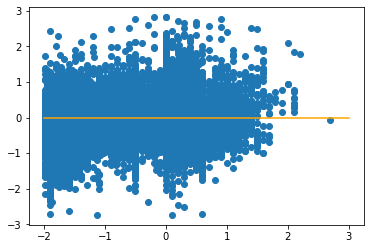

In [64]:
x_use = x
y_use = list(y)
y_pred = a*x_unique+b
x_ind = (x_use+2)*10
residuals = []
x_plot = []
y_plot = []
for i in range(0, len(x_use)):
    if abs(y_pred[int(x_ind[i])]-y_use[i]) <3:
        residuals.append(y_pred[int(x_ind[i])]-y_use[i])
        x_plot.append(x_use[i])
        y_plot.append(y_use[i])
plt.scatter(x_plot, residuals)
plt.plot([-2,3],[0,0], color = 'orange')
#plt.savefig('/home/earthquakes1/homes/Rebecca/phd/seismo_det/figures/iv2_residual_plot.pdf')

In [65]:
mu = np.mean(np.ma.masked_invalid(y_use))
std = np.std(np.ma.masked_invalid(y_use))

/tmp/ipykernel_2086823/1824649760.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  ax2.plot(x_pdf, p, 'k', linewidth=2, color = 'red')


(0.0, 0.4570297707788849)

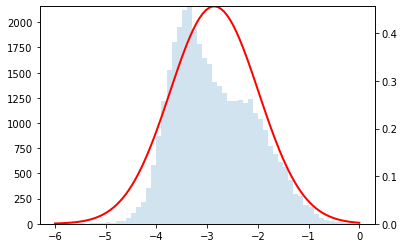

In [66]:
ax = plt.subplot()
x_pdf = np.linspace(-6, 0, 100)
n, bins, _ = plt.hist(np.ma.masked_invalid(y_plot), np.arange(-6,0,0.1), alpha = 0.2)
#plt.close()
p = norm.pdf(x_pdf, mu, std)

#ax.hist(np.ma.masked_invalid(y_use), np.arange(-12,3,0.1), alpha = 1)
ax2 = ax.twinx()
ax2.plot(x_pdf, p, 'k', linewidth=2, color = 'red')
ax.set_ylim([0,max(n)])
ax2.set_ylim([0,max(p)])

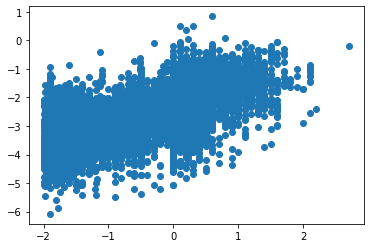

In [67]:
plt.scatter(x_plot,y_plot)

In [69]:
df3['pgd'].skew()
df3['pgd'].kurtosis()

17.874122112965487